In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score,mean_absolute_error 
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, SelectKBest, f_classif,chi2, VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Algorithm Imports
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

In [37]:
dataset = pd.read_csv(r'C:\Users\BIOLA\Desktop\Data Science Projects\Capstone Project\Works\Inter_Track Project\Group3\Inter_Track Project\data.csv', sep= ';')

In [3]:
dataset

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [4]:
# Check for Null values
dataset.isnull().sum().sort_values(ascending = False).head()

Marital status                            0
Age at enrollment                         0
Curricular units 1st sem (credited)       0
Curricular units 1st sem (enrolled)       0
Curricular units 1st sem (evaluations)    0
dtype: int64

In [355]:
# Show correlation between the features and the output
from scipy.stats import spearmanr

d =dataset.copy()
d.drop('Target', axis = 1, inplace = True)
feat_cols = [i for i in d.columns] # create a list of the columns in the dataset
s = dataset.Target.replace({'Graduate':1, 'Enrolled':2, 'Dropout': 3}) # Binary Encode

correlated = []
uncorrelated = []

# Using Spearman's correlation.
for i in feat_cols:
	coef, p = spearmanr(s, d[feat_cols][i].values)
	# print('Spearmans correlation coefficient: %.3f' % coef)
	# interpret the significance
	alpha = 0.05
	if coef > 0.65:
		# print('Samples are uncorrelated p=%.3f' % p)
		correlated.append(p)
	else:
		uncorrelated.append(p)
		# print('Samples are correlated (reject H0) p=%.3f' % p)

cor = pd.DataFrame(correlated)
uncor = pd.DataFrame(uncorrelated)
# we could concat 'cor' and 'uncur' together alog the same axis, but 'cor has no value. No feature is correlated
uncor.head()

,0
0,4.987015e-12
1,4.908589e-47
2,9.587602e-12
3,3.476977e-01
4,1.144709e-06


###### We coudn't concat 'cor and 'uncor', but 'cor' (relating to correlated features) has no content. This basically implies that there are no correlated features  

------------------------
### Feature Engineering

In [356]:
ds = dataset.copy()

In [38]:
dac = dataset.loc[dataset['Curricular units 1st sem (credited)'] != 0]
dvc = dataset.loc[dataset['Curricular units 2nd sem (credited)'] != 0]
dvc = dvc.loc[(dvc['Curricular units 2nd sem (approved)'] >= 4 ) & 
                    (dataset['Curricular units 2nd sem (approved)'] <=24 )]
dvc = dvc.loc[(dvc['Curricular units 1st sem (approved)'] >= 4 ) & 
                    (dvc['Curricular units 1st sem (approved)'] <=24 )]
dvc.shape

(439, 37)

###### Removing the Zero unit 'Curricular units 1st sem (credited)' will makes the available dataset too little to make predictive insights

In [39]:
# Stream down student based on the units approved for each students
# Remove those who have above 18 units, and those who have below 5 units approved for them

ds = dataset.loc[(dataset['Curricular units 2nd sem (approved)'] >= 5 ) & 
                    (dataset['Curricular units 2nd sem (approved)'] <=18 )]
ds = ds.loc[(ds['Curricular units 1st sem (approved)'] >= 5 ) & 
                    (ds['Curricular units 1st sem (approved)'] <=18 )]
ds.shape

(2334, 37)

In [40]:
# Convert other values to 2 which signifies other categories apart from single
def Marriage_Binning (value):
    if value is not 1:
        return 2
    else:
        return value
ds["Marital status"] = ds["Marital status"].apply(Marriage_Binning).values.astype(str)
ds["Marital status"].value_counts()

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\BIOLA\AppData\Local\Temp\ipykernel_26240\1259061387.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if value is not 1:


1    2108
2     226
Name: Marital status, dtype: int64

In [41]:
# Replace outlier values with mode and turn column to string column
ds['Course'] = ds['Course'].replace({33:9130, 9556:9130}).apply(str)
# ds['Course'].value_counts()

In [42]:
ds['Previous qualification'] = ds['Previous qualification'].replace({38:9, 4:9, 43:9, 10:9, 15:9, 5:9, 14:9}).apply(str)
# ds['Previous qualification'].value_counts()

In [43]:
# Identify numerical features
ds.select_dtypes(include = np.number).columns.shape

# There are 33 numerical columns and 4 categorical columns

(33,)

In [44]:
# As it seems, almost all columns are numerical, we need to put them into their various feature dtypes
def transform(x):
    x = str(x) # Transform necessary columns to string
    return x

cols = ['Tuition fees up to date', 'Marital status', 'Course', 'Previous qualification',
        'Gender', 'Scholarship holder', 'Debtor', 'Daytime/evening attendance\t' ]

for i in cols:
        ds[i] = ds[i].apply(transform)

In [45]:
# Drop the Enrolled entry in the target column to focus on the problem statement
ds = ds.drop(ds.loc[ds['Target'] == 'Enrolled'].index)

In [364]:
# Display Features and their types

ed = ds.columns.tolist()
dj = ds.dtypes.tolist()
gg = ({'Features': ed, 'Dtypes': dj})
gj = pd.DataFrame(gg)
gj

,Features,Dtypes
0,Marital status,object
1,Application mode,int64
2,Application order,int64
3,Course,object
4,Daytime/evening attendance\t,object
5,Previous qualification,object
6,Previous qualification (grade),float64
7,Nacionality,int64
8,Mother's qualification,int64
9,Father's qualification,int64


-------------------------------
## Feature Preprocessing

In [46]:
df = ds.copy()
df.shape

(2056, 37)

###### Analysing Low Variance.

In [36]:
# Seperate into Categorical and Numerical Features
num = df.select_dtypes(include = [np.number])
cat = df.select_dtypes(exclude = [np.number])

# Get columns with low variance
low_var = VarianceThreshold(threshold = 0)
low_var.fit_transform(num) 
cols = low_var.get_support(indices = True)
num_1 = num.iloc[:, cols]

num_1

,Application order,Previous qualification (grade),Admission grade,Educational special needs,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
1,1,160.0,142.5,0,19,0,0,6,6,6,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
3,2,122.0,119.6,0,20,0,0,6,8,6,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,1,100.0,141.5,0,45,0,0,6,9,5,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79
5,1,133.1,114.8,0,50,0,0,5,10,5,...,0,0,5,17,5,11.500000,5,16.2,0.3,-0.92
6,1,142.0,128.4,0,18,0,0,7,9,7,...,0,0,8,8,8,14.345000,0,15.5,2.8,-4.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,1,132.0,133.8,0,20,0,0,6,6,6,...,0,0,6,6,6,13.500000,0,16.2,0.3,-0.92
4418,1,120.0,120.0,0,20,0,2,7,7,6,...,0,5,9,10,7,13.142857,1,16.2,0.3,-0.92
4419,6,125.0,122.2,0,19,0,0,6,7,5,...,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06
4422,1,180.0,153.8,0,20,0,0,5,5,5,...,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12


###### It did not drop any column because none has a Variance of Zero

In [47]:
# Convert columns to Categrical features

def transform(x):
    x = str(x) # Transform necessary columns to string
    return x

cols = ['Displaced', "Father's occupation", "Mother's occupation", 'Previous qualification',
        "Mother's qualification", "Father's qualification", 'Nacionality', 'Application mode' ]

for i in cols:
        df[i] = df[i].apply(transform)

In [62]:
# Split into test and train
y = df['Target']
X = df.drop(['Target'], axis = 1) 

Optimal number of features : 25


c:\Users\BIOLA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


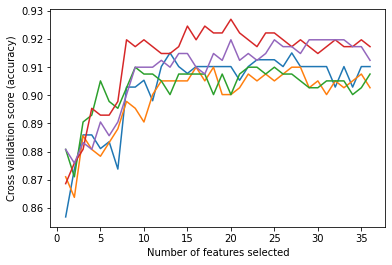

In [63]:
# conduct feature selection 

min_features_to_select = 1
rfe = RandomForestClassifier(random_state = 32) # Instantiate the algo
rfecv  = RFECV(estimator = rfe, step=1, cv=StratifiedKFold(5, random_state = None), scoring="accuracy") # Instantiate the RFECV and its parameters
fit = rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,)
plt.show()

###### From the graph, we could see that the number of features got optimal at 25, hence we use 25 features <br>

In [64]:
# Set columns to select at 25 and drop the rest
# Print out the columns to remove
rfc = RandomForestClassifier()
rfe = RFE(estimator=rfc, n_features_to_select= 25, step=1)
fittings1 = rfe.fit(X, y)
for i in range(X.shape[1]):
	# print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    columns_to_remove = X.columns.values[np.logical_not(rfe.support_)]
columns_to_remove

array(['Marital status', 'Daytime/evening attendance\t',
       'Previous qualification', 'Nacionality', 'Displaced',
       'Educational special needs', 'Gender', 'Scholarship holder',
       'International', 'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (without evaluations)'], dtype=object)

In [65]:
# Display the columns adviced by RFECV
gh = X.copy()
gh.drop(columns_to_remove, axis = 1, inplace = True)
gh.head(4)

,Application mode,Application order,Course,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Debtor,...,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP
1,15,1,9254,160.0,1,3,3,3,142.5,0,...,6,14.000000,0,6,6,6,13.666667,13.9,-0.3,0.79
3,17,2,9773,122.0,38,37,5,3,119.6,0,...,6,13.428571,0,6,10,5,12.400000,9.4,-0.8,-3.12
4,39,1,8014,100.0,37,38,9,9,141.5,0,...,5,12.333333,0,6,6,6,13.000000,13.9,-0.3,0.79
5,39,1,9991,133.1,37,37,9,7,114.8,1,...,5,11.857143,0,5,17,5,11.500000,16.2,0.3,-0.92


###### These above are the features adviced by the Recursive Feature Elimination

In [66]:
# Using SelectKBest 

best_feature = SelectKBest(score_func = f_classif, k = 36)
fitting = best_feature.fit(X,y)

scores = pd.DataFrame(fitting.scores_)
columns = pd.DataFrame(X.columns)

feat_score = pd.concat([scores, columns], axis = 1)
feat_score.columns = ['score', 'column'] 

k = feat_score.nlargest(25, 'score')
k

,score,column
16,249.716723,Tuition fees up to date
15,86.643766,Debtor
21,80.670323,Curricular units 1st sem (credited)
27,73.174455,Curricular units 2nd sem (credited)
23,61.684712,Curricular units 1st sem (evaluations)
29,58.268806,Curricular units 2nd sem (evaluations)
22,45.681877,Curricular units 1st sem (enrolled)
19,40.608750,Age at enrollment
18,39.951061,Scholarship holder
31,33.970110,Curricular units 2nd sem (grade)


In [68]:
# Based on the two feature Selection approved, we select the following features for production

sel_cols = ['Course', 'Age at enrollment', 'Curricular units 1st sem (credited)','Curricular units 1st sem (grade)', 'Curricular units 2nd sem (credited)', 
            'Curricular units 2nd sem (grade)','Scholarship holder', 'Debtor',  'Previous qualification (grade)', 'Gender', "Daytime/evening attendance\t", 
            'Marital status', 'Tuition fees up to date']

In [69]:
X = X[sel_cols]
X

,Course,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (grade),Curricular units 2nd sem (credited),Curricular units 2nd sem (grade),Scholarship holder,Debtor,Previous qualification (grade),Gender,Daytime/evening attendance\t,Marital status,Tuition fees up to date
1,9254,19,0,14.000000,0,13.666667,0,0,160.0,1,1,1,0
3,9773,20,0,13.428571,0,12.400000,0,0,122.0,0,1,1,1
4,8014,45,0,12.333333,0,13.000000,0,0,100.0,0,0,2,1
5,9991,50,0,11.857143,0,11.500000,0,1,133.1,1,0,2,1
6,9500,18,0,13.300000,0,14.345000,1,0,142.0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,9070,20,0,13.833333,0,13.500000,1,0,132.0,0,1,1,1
4418,9070,20,2,12.500000,5,13.142857,0,0,120.0,1,1,1,1
4419,9773,19,0,13.600000,0,12.666667,0,0,125.0,1,1,1,1
4422,9147,20,0,13.800000,0,12.000000,1,0,180.0,0,1,1,1


In [70]:
# Rename columns and replace content where needed

X.rename(columns = {'Daytime/evening attendance\t': 'Attendance'},   inplace = True) 
X['Attendance'] = X['Attendance'].replace({'1': 'present', '0': 'absent'})

X['Marital status'] = X['Marital status'].replace({'1': 'single', '2': 'married'})

X.rename({'Course': 'Course Code'}, inplace = True, axis = 1)

X['Tuition fees up to date'] = X['Tuition fees up to date'].replace({'1': 'yes', '0': 'no'})

X['Gender'] = X['Gender'].replace({'0': 'male', '1':'female'})

X['Scholarship holder'] = X['Scholarship holder'].replace({'1': 'yes', '0': 'no'})

X['Debtor'] = X['Debtor'].replace({'1': 'yes', '0': 'no'})

X['CGPA'] = (X['Curricular units 1st sem (grade)'] + X['Curricular units 2nd sem (grade)']) / 7.2

# Create a new column to show the percentage Dropoff and Appreciation rate
X['DropOff_Rate'] = ((X['Curricular units 2nd sem (grade)'] - X['Curricular units 1st sem (grade)']) / 
                X['Curricular units 1st sem (grade)']).apply(lambda x: x if x<0 else 0)
X['Appreciation_Rate'] = ((X['Curricular units 2nd sem (grade)'] - X['Curricular units 1st sem (grade)']) / 
                X['Curricular units 1st sem (grade)']).apply(lambda x: x if x>0 else 0)
# % Increase = (New Value = Old Value) / Old Value

X['DropOff_Rate'] = X['DropOff_Rate'].round(2)
X['Appreciation_Rate'] = X['Appreciation_Rate'].round(2)


X.reset_index(drop = True)

,Course Code,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (grade),Curricular units 2nd sem (credited),Curricular units 2nd sem (grade),Scholarship holder,Debtor,Previous qualification (grade),Gender,Attendance,Marital status,Tuition fees up to date,CGPA,DropOff_Rate,Appreciation_Rate
0,9254,19,0,14.000000,0,13.666667,no,no,160.0,female,present,single,no,3.842593,-0.02,0.00
1,9773,20,0,13.428571,0,12.400000,no,no,122.0,male,present,single,yes,3.587302,-0.08,0.00
2,8014,45,0,12.333333,0,13.000000,no,no,100.0,male,absent,married,yes,3.518519,0.00,0.05
3,9991,50,0,11.857143,0,11.500000,no,yes,133.1,female,absent,married,yes,3.244048,-0.03,0.00
4,9500,18,0,13.300000,0,14.345000,yes,no,142.0,male,present,single,yes,3.839583,0.00,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,9070,20,0,13.833333,0,13.500000,yes,no,132.0,male,present,single,yes,3.796296,-0.02,0.00
2052,9070,20,2,12.500000,5,13.142857,no,no,120.0,female,present,single,yes,3.561508,0.00,0.05
2053,9773,19,0,13.600000,0,12.666667,no,no,125.0,female,present,single,yes,3.648148,-0.07,0.00
2054,9147,20,0,13.800000,0,12.000000,yes,no,180.0,male,present,single,yes,3.583333,-0.13,0.00


In [71]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14, stratify = y)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print('y_train: {}'.format(y_train.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1644, 16)
X_test: (412, 16)
y_train: (1644,)
y_test: (412,)


------------------------------------------
### Modelling with Pipeline 

In [72]:
# Data Preprocessing with Standard scaler
# Reduce Dimensinaltiy
# Apply Classifier (Logistic Regression, Random Forest, SVM, Naive Bayes)

pipeline_rf = Pipeline([('encoding1', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler1', StandardScaler(with_mean=False)),
                    ('classifier1', RandomForestClassifier())
])

In [73]:
pipeline_lr = Pipeline([('encoding2', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler2', StandardScaler(with_mean=False)),
                    ('classifier2', LogisticRegression())
])

In [74]:
pipeline_svc = Pipeline([('encoding3', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler3', StandardScaler(with_mean = False)),
                    ('classifier3', SVC())
])

In [75]:
pipeline_nb = Pipeline([('encoding4', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler4', StandardScaler(with_mean=False)),
                    ('classifier4', GaussianNB())
])

###### According to the Sklearn documentation, the OneHot encoding passes a Sparse Matrix. Meanwhile, the Standard Scaler, having a default 'with_mean = True' raises an exception when attempted on a Sparse Matrix. This is a because the dataset has not been centered (Having a mean of zero) before scaling. Centering the dataset entails building a dense matrix. Hence <b>(OneHotEncoder(sparse = False))<b> <br>
###### "Handle_Unknown = 'Ignore'. This solves the problem that comes up when a model encounters a value in the test data that it had not seen in the training data. Hence, <b>OneHotEncoder(sparse = False, handle_unknown = 'ignore')<b>.

In [76]:
# Create a list of the pipeline
pipelines = [pipeline_rf, pipeline_lr, pipeline_svc, pipeline_nb]

# Create a dictionary of Pipelines for ease of reference 
pipe_dict = {0: 'Random Forest', 1: 'Logistic Regression', 2: 'Support Vector', 3: 'Naive Bayesian'}

In [77]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [78]:
# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

c:\Users\BIOLA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
for i, model in enumerate(pipelines):
    print(f'\n{pipe_dict[i]} Training Accuracy: {model.score(X_train, y_train)}')


Random Forest Training Accuracy: 1.0

Logistic Regression Training Accuracy: 1.0

Support Vector Training Accuracy: 0.9482968369829684

Naive Bayesian Training Accuracy: 0.9227493917274939


In [80]:
for i, model in enumerate(pipelines):
    print(f'\n{pipe_dict[i]} Test Accuracy: {model.score(X_test, y_test)}')


Random Forest Test Accuracy: 0.9077669902912622

Logistic Regression Test Accuracy: 0.8519417475728155

Support Vector Test Accuracy: 0.8932038834951457

Naive Bayesian Test Accuracy: 0.6067961165048543


In [81]:
for i, models in enumerate(pipelines):
    if models.score(X_test, y_test) > best_accuracy:
        best_accuracy = models.score(X_test, y_test)
        best_pipeline = model
        best_classifier = i
print(f'Classifier with the best accuracy: {pipe_dict[best_classifier]}')

Classifier with the best accuracy: Random Forest


In [83]:
pipeline_rf

Pipeline(steps=[('encoding1',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('scaler1', StandardScaler(with_mean=False)),
                ('classifier1', RandomForestClassifier())])

In [391]:
# Save the model
import pickle

filename = 'pipeline_model.pkl'
pickle.dump(pipeline_rf, open(filename, 'wb'))

In [395]:
# Testing the  the predictve system

input = [9254,19,0,14.000000,0,13.666667,'no','no',160.0,'female','present','single','no',3.842593,-0.02,0.00]
input_array = pd.DataFrame(input) # Change the input to a Dataframe 

# Since 2056 rows and 16 columns was used to build the model, it expects 16 columns
# Hence we need to reshape the input, meaning we need prediction for one data point
# hence, Transpose the dataframe to turn rows to columns
input_reshape = input_array.transpose() 
# input_reshape = input.reshape(1, -1)

prediction = pipeline_rf.predict(input_reshape)

if (prediction[0] == 'Graduated'):
    print('Graduated')
else:
    print('Dropout')

Dropout


c:\Users\BIOLA\Desktop\Data Science Projects\Capstone Project\Works\Inter_Track Project\Group3\dep\venvs\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [398]:
# Model Features and their types

ed = X.columns.tolist()
dj = X.dtypes.tolist()
gg = ({'Features': ed, 'Dtypes': dj})
gj = pd.DataFrame(gg)
gj


,Features,Dtypes
0,Course Code,object
1,Age at enrollment,int64
2,Curricular units 1st sem (credited),int64
3,Curricular units 1st sem (grade),float64
4,Curricular units 2nd sem (credited),int64
5,Curricular units 2nd sem (grade),float64
6,Scholarship holder,object
7,Debtor,object
8,Previous qualification (grade),float64
9,Gender,object


### Dataset Creation for Backend and UI/UX

In [30]:
# Selected columns for the backend 
sel_cols1 = ['Course', 'Age at enrollment', 'Curricular units 1st sem (credited)','Curricular units 1st sem (grade)', 'Curricular units 2nd sem (credited)', 
            'Curricular units 2nd sem (grade)','Scholarship holder', 'Debtor',  'Previous qualification (grade)', 'Gender', "Daytime/evening attendance\t", 
            'Marital status', 'Tuition fees up to date', 'Target']

# Append the new selected columns to Dataframe
dv = df.copy()
dv = dv[sel_cols1]

In [33]:
# Adding the Target feature to previously created dataframe

dv.rename(columns = {'Daytime/evening attendance\t': 'Attendance'},   inplace = True) 
dv['Attendance'] = dv['Attendance'].replace({'1': 'present', '0': 'absent'})

dv['Marital status'] = dv['Marital status'].replace({'1': 'single', '2': 'married'})

dv.rename({'Course': 'Course Code'}, inplace = True, axis = 1)

dv['Tuition fees up to date'] = dv['Tuition fees up to date'].replace({'1': 'yes', '0': 'no'})

dv['Gender'] = dv['Gender'].replace({'0': 'male', '1':'female'})

dv['Scholarship holder'] = dv['Scholarship holder'].replace({'1': 'yes', '0': 'no'})

dv['Debtor'] = dv['Debtor'].replace({'1': 'yes', '0': 'no'})

dv['CGPA'] = (dv['Curricular units 1st sem (grade)'] + dv['Curricular units 2nd sem (grade)']) / 7.2

# Create a new column to show the drop off and the appreciation rate
dv['DropOff_Rate'] = (dv['Curricular units 1st sem (grade)'] - dv['Curricular units 2nd sem (grade)']).round(2)
dv['Appreciation_Rate'] = (dv['Curricular units 2nd sem (grade)'] - dv['Curricular units 1st sem (grade)']).round(2)

# Remove negetive numbers from the output by equating it to zero
dv['DropOff_Rate'] = (dv['DropOff_Rate'].apply(lambda x: 0 if x < 0 else x))
dv['Appreciation_Rate'] = dv['Appreciation_Rate'].apply(lambda x: 0 if x < 0 else x )

dv['Target'] = dv['Target'].replace({1: 'Graduate', 2: 'Dropout'})

dv.reset_index(drop = True)

,Course Code,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (grade),Curricular units 2nd sem (credited),Curricular units 2nd sem (grade),Scholarship holder,Debtor,Previous qualification (grade),Gender,Attendance,Marital status,Tuition fees up to date,Target,CGPA,DropOff_Rate,Appreciation_Rate
0,9254,19,0,14.000000,0,13.666667,no,no,160.0,female,present,single,no,Graduate,3.842593,0.33,0.00
1,9773,20,0,13.428571,0,12.400000,no,no,122.0,male,present,single,yes,Graduate,3.587302,1.03,0.00
2,8014,45,0,12.333333,0,13.000000,no,no,100.0,male,absent,married,yes,Graduate,3.518519,0.00,0.67
3,9991,50,0,11.857143,0,11.500000,no,yes,133.1,female,absent,married,yes,Graduate,3.244048,0.36,0.00
4,9500,18,0,13.300000,0,14.345000,yes,no,142.0,male,present,single,yes,Graduate,3.839583,0.00,1.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,9070,20,0,13.833333,0,13.500000,yes,no,132.0,male,present,single,yes,Graduate,3.796296,0.33,0.00
2052,9070,20,2,12.500000,5,13.142857,no,no,120.0,female,present,single,yes,Graduate,3.561508,0.00,0.64
2053,9773,19,0,13.600000,0,12.666667,no,no,125.0,female,present,single,yes,Graduate,3.648148,0.93,0.00
2054,9147,20,0,13.800000,0,12.000000,yes,no,180.0,male,present,single,yes,Graduate,3.583333,1.80,0.00


In [35]:
# Save data to csv
dv.to_csv(r"C:\Users\BIOLA\Desktop\Data Science Projects\Capstone Project\Works\Inter_Track Project\Group3\dep\Predact_data.csv",encoding = 'utf-8')